Index เป็น unique หรือไม่: True
                        pm_2_5  temperature   humidity  pm_2_5_sp_lag15  \
timestamp                                                                 
2022-05-17 07:00:00  15.788506    27.948805  72.038097        21.110274   
2022-05-18 07:00:00   9.481538    30.198423  67.144211        18.678202   
2022-05-19 07:00:00  24.730858    30.807471  65.339858        12.097507   
2022-05-20 07:00:00  14.737404    31.920448  57.033495        20.946168   
2022-05-21 07:00:00  11.706139    31.173422  59.517832        19.034483   
...                        ...          ...        ...              ...   
2025-02-07 07:00:00  19.059025    29.077198  68.224688        31.186038   
2025-02-08 07:00:00  19.064854    29.716301  65.974686        22.123305   
2025-02-09 07:00:00  13.824501    29.145664  66.850779        17.109808   
2025-02-10 07:00:00  18.744632    29.690582  67.651647        26.194777   
2025-02-11 07:00:00  25.979693    29.804851  66.932706        10.158

,Description,Value
0,session_id,123
1,Target,pm_2_5
2,Approach,Univariate
3,Exogenous Variables,Present
4,Original data shape,"(988, 121)"
5,Transformed data shape,"(988, 121)"
6,Transformed train set shape,"(974, 121)"
7,Transformed test set shape,"(14, 121)"
8,Rows with missing values,0.0%
9,Fold Generator,ExpandingWindowSplitter


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: gfx1035, Vendor: Advanced Micro Devices, Inc.
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves

,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2024-12-03,1.0626,1.0468,6.9445,9.1416,0.5687,0.7681,-1.2805
1,2024-12-17,1.3029,1.1927,8.5005,10.3989,0.5438,0.7174,-0.9070
2,2024-12-31,2.0063,1.7303,13.1354,15.1276,0.4401,0.5972,-4.5844
Mean,NaT,1.4573,1.3233,9.5268,11.5561,0.5176,0.6943,-2.2573
SD,NaT,0.4005,0.2939,2.6295,2.5771,0.0557,0.0717,1.6526


<function matplotlib.pyplot.title(label, fontdict=None, loc=None, pad=None, *, y=None, **kwargs)>

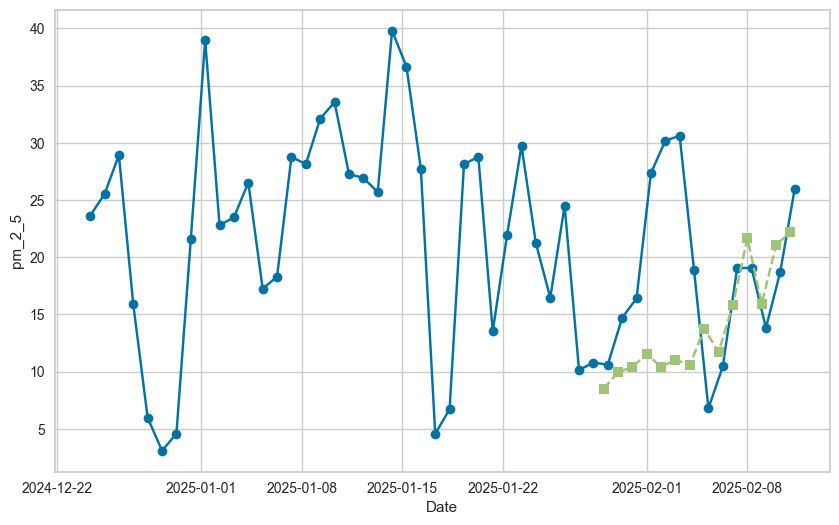

In [67]:
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
from pycaret.time_series import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pycaret.utils.time_series import clean_time_index
import holidays
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

# อ่านข้อมูลจากไฟล์ CSV
df = pd.read_csv(
    "daily_csv/export-jsps014-1d.csv", parse_dates=["timestamp"], index_col="timestamp"
)
df = df.drop(columns=["Unnamed: 0"], errors="ignore")
print("Index เป็น unique หรือไม่:", df.index.is_unique)

df = df[:]
# ลบ index ที่ซ้ำกันและตั้งค่าความถี่เป็นรายวัน
df = df[~df.index.duplicated(keep="last")]
df = df.interpolate(method="spline", order=2)
df = df.asfreq("D")

# กำหนดเกณฑ์สำหรับค่า pm_2_5
df = df[(df["pm_2_5"] >= 0) & (df["pm_2_5"] <= 100)]
df = df[(df["pm_2_5_sp"] >= 0) & (df["pm_2_5_sp"] <= 130)]

# ใช้เฉพาะคอลัมน์ที่ต้องการ
df = df[["pm_2_5", "pm_2_5_sp", "temperature", "humidity"]]  # เพิ่ม temperature และ humidity

# สร้าง Lag Features สำหรับ pm_2_5_sp
for lag in range(15, 45,2):
    df[f"pm_2_5_sp_lag{lag}"] = df["pm_2_5_sp"].shift(lag)

# สร้าง Lag Features สำหรับ pm_2_5
for lag in range(15, 45,2):
    df[f"pm_2_5_lag{lag}"] = df["pm_2_5"].shift(lag)

# สร้าง Lag Features สำหรับ temperature และ humidity
for lag in range(15, 45,2):
    df[f"temperature_lag{lag}"] = df["temperature"].shift(lag)
    df[f"humidity_lag{lag}"] = df["humidity"].shift(lag)

# Shift pm_2_5 ไป 15 วันก่อน
df["pm_2_5_shift15"] = df["pm_2_5"].shift(15)
df["pm_2_5_sp_shift15"] = df["pm_2_5_sp"].shift(15)
df["temperature_shift15"] = df["temperature"].shift(15)
df["humidity_shift15"] = df["humidity"].shift(15)

windows = range(1, 30,2)  # ตั้งแต่ 1 ถึง 17 วัน

# คำนวณค่าเฉลี่ยย้อนหลังโดยใช้ลูป
for window in windows:
    df[f"pm_2_5_ma{window}"] = df["pm_2_5"].shift(15).rolling(window=window).mean()
    df[f"pm_2_5_sp_ma{window}"] = df["pm_2_5_sp"].shift(15).rolling(window=window).mean()
    df[f"temperature_ma{window}"] = df["temperature"].shift(15).rolling(window=window).mean()
    df[f"humidity_ma{window}"] = df["humidity"].shift(15).rolling(window=window).mean()

# ลบคอลัมน์ shift ที่ไม่ต้องการออก
df = df.drop(columns=["pm_2_5_shift15"])
df = df.drop(columns=["pm_2_5_sp_shift15"])
df = df.drop(columns=["temperature_shift15"])
df = df.drop(columns=["humidity_shift15"])

# ลบคอลัมน์ pm_2_5_sp ที่ไม่ต้องการใช้
df = df.drop(columns="pm_2_5_sp")
df = df[-1000:]
print(df)

# Ensure the DataFrame has a DateTime index with a frequency
df = df.asfreq("D")  # Set frequency to daily

# Fill any missing values after setting the frequency
df = df.interpolate(method="linear", limit_direction="forward")

# Split the data into train and test sets
train_size = len(df) - 14
train_df = df.iloc[:train_size]
test_df = df.iloc[train_size:]

# Ensure the train and test sets have a frequency
train_df = train_df.asfreq("D")
test_df = test_df.asfreq("D")

# ลบคอลัมน์ที่ไม่ต้องการใช้
train_df = train_df.drop(columns=["temperature", "humidity"])
test_df = test_df.drop(columns=["pm_2_5", "temperature", "humidity"])


# Set up PyCaret
exp = TSForecastingExperiment()
exp.setup(
    data=train_df,  # Use train_df with a defined frequency
    target="pm_2_5",
    session_id=123,
    fh=14,  # Forecast horizon
    use_gpu=True,
)

# Create and finalize the ARIMA model
model = exp.create_model("arima", order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
# model = exp.tune_model(model)
model = exp.finalize_model(model)
# exp.plot_model(model, plot="forecast")

# แปลงดัชนีของ test_df เป็น PeriodIndex ก่อนทำนาย
test_df_period = test_df.copy()
test_df_period.index = test_df_period.index.to_period("D")

# Make predictions
forecast = exp.predict_model(model, fh=14, X=test_df_period)

# Ensure predictions are non-negative
forecast["y_pred"] = np.maximum(forecast["y_pred"], 0)

# แปลงดัชนีของ forecast กลับเป็น datetime64[ns] เพื่อการพล็อตกราฟ
forecast.index = forecast.index.to_timestamp()

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(df.index[-50:], df["pm_2_5"][-50:], label="Actual", marker="o")
plt.plot(
    forecast.index,
    forecast["y_pred"],
    label="Forecast",
    marker="s",
    linestyle="dashed",
)
plt.xlabel("Date")
plt.ylabel("pm_2_5")
plt.title

In [ ]:
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    mean_absolute_percentage_error,
    r2_score
)
import numpy as np

# ดึงค่าจริงจาก test_df
actual = df[-14:]['pm_2_5']

# ดึงค่าทำนายจาก forecast
predicted = forecast['y_pred']

# คำนวณ MAE
mae = mean_absolute_error(actual, predicted)

# คำนวณ MSE
mse = mean_squared_error(actual, predicted)

# คำนวณ RMSE
rmse = np.sqrt(mse)

# คำนวณ MAPE โดยใช้ฟังก์ชันจาก sklearn
mape = mean_absolute_percentage_error(actual, predicted) * 100  # แปลงเป็นเปอร์เซ็นต์

# คำนวณ R²
r2 = r2_score(actual, predicted)

# คำนวณความแม่นยำ (Accuracy)
mean_actual = np.mean(actual)
accuracy = 100 - mape 

# แสดงผลลัพธ์
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.4f}")
print(f"ความแม่นยำ (Accuracy): {accuracy:.2f}%")


MAE: 7.0415
MSE: 89.0796
RMSE: 9.4382
MAPE: 36.25%
R²: -0.7277
ความแม่นยำ (Accuracy): 63.75%
